In [34]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import joblib
from collections import namedtuple
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [26]:
test_dir = "key_word_test.csv"
df_test = pd.read_csv(test_dir)
df_test_10 = pd.DataFrame(df_test,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_test_10.name = 'df_test_10'
df_test_20 = pd.DataFrame(df_test,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_test_20.name = 'df_test_20'
df_test_50 = pd.DataFrame(df_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

test_size = len(df_test)

In [27]:
topic_list = list(set(df_test['topic']))
topic_list.sort()
topic_dict = dict()
for num, topic in enumerate(topic_list):
    topic_dict[num] = topic
print(topic_dict)

{0: 'ARTS CULTURE ENTERTAINMENT', 1: 'BIOGRAPHIES PERSONALITIES PEOPLE', 2: 'DEFENCE', 3: 'DOMESTIC MARKETS', 4: 'FOREX MARKETS', 5: 'HEALTH', 6: 'IRRELEVANT', 7: 'MONEY MARKETS', 8: 'SCIENCE AND TECHNOLOGY', 9: 'SHARE LISTINGS', 10: 'SPORTS'}


In [28]:
# [[first_level_model_path, second_level_model_path],
#  [first_level_model_path, second_level_model_path],
#  ...
#  [first_level_model_path, second_level_model_path]]
model_paths = [["Raymond_work/chosen_models/rel_clf_tfidf_NB.joblib", "Raymond_work/chosen_models/clf_NB_1.joblib"],
               ["Raymond_work/chosen_models/rel_clf_tfidf_NB.joblib", "Raymond_work/chosen_models/clf_NB_2.joblib"],
               ["Raymond_work/chosen_models/rel_clf_tfidf_NB.joblib", "Raymond_work/chosen_models/clf_NB_1.joblib"],
#                ["Shiyunze_work/ChosenModel/tfidf_logi_pipe.joblib"],
#                ["Yangqi's work/svm_model1.joblib"],
#                ["Yangqi's work/svm_model1.joblib"]
              ]

In [29]:
# data used by the models
model_data = [df_test_50, 
              df_test_100, 
              df_test_50, 
#               df_test_50,
              df_test_100,
#               df_test_full
             ]
# order of categories predicted accurately by the models
model_beliefs = [{9, 3, 0, 10, 2, 4}, 
                 {9, 3, 10, 5, 7, 2}, 
                 {1}, 
#                  {0, 3, 10, 9, 5, 2}, 
#                  {0, 9, 3, 10, 2, 4, 5},
#                  {3, 10, 4, 5, 2}
                ]

In [30]:
# create a Vote structure include following information:
#    voter: which model votes             - int
#    cate:  which category it votes       - int
#    proba: the probability it provides   - float
Vote = namedtuple("Vote", "model cate proba")

# since some cannot predict proba, try vote without proba, but probably get a draw vote
def print_vote(truth, votes):
    for num, (label, sample) in enumerate(zip(truth, votes)):        
        # vote_list to count vote, init with 11 zeros
        vote_list = [0 for _ in range(len(topic_list))]
        for vote in sample:
            vote_list[vote.cate] += 1
            
        # get category chosen by vote
        max_vote = max(vote_list)
        # 
        if max_vote == 0:
            raise ValueError("No valid vote")
        if vote_list.count(max_vote) > 1:
            raise ValueError("Draw vote")
        chosen_cate = vote_list.index(max_vote)
        print(num, label, topic_dict[chosen_cate])


def vote_proba(truth, votes):
    column_names = ['label', 'predict', 'mean_proba']
    df = pd.DataFrame(columns = column_names)
    for num, (label, sample) in enumerate(zip(truth, votes)):        
        # vote_list to count vote, init with 11 zeros
        vote_list = [0 for _ in range(len(topic_list))]
        vote_probas = [[] for _ in range(len(topic_list))]
        vote_proba_mean = [0 for _ in range(len(topic_list))]
        for vote in sample:
            vote_list[vote.cate] += 1
            vote_probas[vote.cate].append(vote.proba)
            
        for i in range(len(topic_list)):
            if len(vote_probas[i]) > 0:
                vote_proba_mean[i] = sum(vote_probas[i])/len(vote_probas[i])
            
        # get category chosen by vote
        max_vote = max(vote_list)
        # 
        if max_vote == 0:
            raise ValueError("No valid vote")
        if vote_list.count(max_vote) > 1:
            chosen_cate = vote_proba_mean.index(max(vote_proba_mean))
        else:
            chosen_cate = vote_list.index(max_vote)
        new_row = pd.Series([label, topic_dict[chosen_cate], vote_proba_mean[chosen_cate]], index=column_names)
        df = df.append(new_row, ignore_index=True)
    return df

In [31]:
# after first level, change 0 to 6
CLASS_IRRE = 6

all_votes = [[] for _ in range(test_size)]

for model_num, (data, path) in enumerate(zip(model_data, model_paths)):
    # if path have two strings, means model have 2 levels
    if len(path) == 2:
        # prediction at first level (i.e., relevant vs irrelevant)
        model_1 = joblib.load(path[0])
        y_pred_1 = model_1.predict(data['key_word'])
        y_pred_proba_1 = model_1.predict_proba(data['key_word'])
        for i in range(test_size):
            cate_1, proba_1 = y_pred_1[i], y_pred_proba_1[i]
            if cate_1 == 0:
                all_votes[i].append(Vote(model_num, CLASS_IRRE, proba_1[cate_1]))

        # prediction at second level
        model_2 = joblib.load(path[1])
        y_pred_2 = model_2.predict(data['key_word'])
        y_pred_proba_2 = model_2.predict_proba(data['key_word'])
        for i in range(test_size):
            # cate_1 use to distinguish relavent
            cate_1 = y_pred_1[i]
            cate_2, proba_2 = y_pred_2[i], y_pred_proba_2[i]
            accu_class = model_beliefs[model_num]

            # if first level predict relevant, predict by 2 level
            # if it's accurately classified by the first level, vote is valid
            if cate_1 == 1 and cate_2 in accu_class:
                all_votes[i].append(Vote(model_num, cate_2, proba_2[cate_2]))
    
    # if path have 1 string, means model have 1 level
    else:
        model = joblib.load(path[0])
        y_pred = model.predict(data['key_word'])
        y_pred_proba = model.predict_proba(data['key_word'])
        for i in range(test_size):
            cate, proba = y_pred[i], y_pred_proba[i]
            accu_class = model_beliefs[model_num]

            # if first level predict relevant, predict by 2 level
            # if it's accurately classified by the first level, vote is valid
            if cate in accu_class:
                all_votes[i].append(Vote(model_num, cate, proba[cate]))

df = vote_proba(df_test['topic'], all_votes)

In [32]:
df

,label,predict,mean_proba
0,IRRELEVANT,IRRELEVANT,1.000000
1,IRRELEVANT,IRRELEVANT,0.999884
2,FOREX MARKETS,MONEY MARKETS,1.000000
3,IRRELEVANT,IRRELEVANT,1.000000
4,IRRELEVANT,IRRELEVANT,1.000000
...,...,...,...
495,IRRELEVANT,IRRELEVANT,1.000000
496,SPORTS,SPORTS,1.000000
497,MONEY MARKETS,MONEY MARKETS,1.000000
498,SHARE LISTINGS,IRRELEVANT,0.910855


In [33]:
topic_list = list(set(df.label))
print(topic_list)

['SPORTS', 'MONEY MARKETS', 'SHARE LISTINGS', 'DOMESTIC MARKETS', 'FOREX MARKETS', 'HEALTH', 'BIOGRAPHIES PERSONALITIES PEOPLE', 'ARTS CULTURE ENTERTAINMENT', 'DEFENCE', 'IRRELEVANT', 'SCIENCE AND TECHNOLOGY']


In [36]:
record = []
for topic in topic_list:
    test_df = df[df['label'] == topic]
    accuarcy = accuracy_score(test_df['label'], test_df['predict'])
    print(topic,'accuarcy is:\t\t', accuarcy)
    record.append(accuarcy)


SPORTS accuarcy is:		 0.9666666666666667
MONEY MARKETS accuarcy is:		 0.6521739130434783
SHARE LISTINGS accuarcy is:		 0.14285714285714285
DOMESTIC MARKETS accuarcy is:		 0.5
FOREX MARKETS accuarcy is:		 0.6041666666666666
HEALTH accuarcy is:		 0.42857142857142855
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is:		 0.4666666666666667
ARTS CULTURE ENTERTAINMENT accuarcy is:		 0.6666666666666666
DEFENCE accuarcy is:		 0.7692307692307693
IRRELEVANT accuarcy is:		 0.7556390977443609
SCIENCE AND TECHNOLOGY accuarcy is:		 0.0


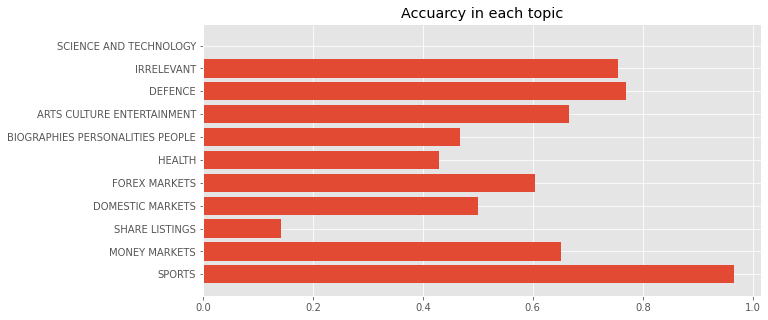

In [47]:
#plt.style.use('ggplot')
figure = plt.figure(figsize=(10,5))
#plt.xticks(rotation=90)
plt.title('Accuarcy in each topic')
plt.barh(topic_list, record)

plt.show()